### Uploading to S3

In [91]:
from utils import *

import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

prefix='dengai'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

train_path  = sagemaker_session.upload_data(TRAIN_JSON, bucket=bucket, key_prefix=train_prefix)
test_path_sj   = sagemaker_session.upload_data(TEST_JSON_SJ,  bucket=bucket, key_prefix=test_prefix)
test_path_iq   = sagemaker_session.upload_data(TEST_JSON_IQ,  bucket=bucket, key_prefix=test_prefix)

### Creating training job

In [6]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator

image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar') 
s3_output_path_sj = "s3://{}/{}/output_sj".format(bucket, prefix)
s3_output_path_iq = "s3://{}/{}/output_iq".format(bucket, prefix)

estimator_sj = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path_sj
                      )

estimator_iq = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path_iq
                      )

hyperparameters_base = {
    "epochs": "50",
    "time_freq": 'W',
    "num_cells": "40",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

hyperparameters_sj = hyperparameters_base.copy()
hyperparameters_sj['prediction_length'] = str(PREDICTION_LENGTH_SJ)
hyperparameters_sj['context_length'] = str(PREDICTION_LENGTH_SJ)

hyperparameters_iq = hyperparameters_base.copy()
hyperparameters_iq['prediction_length'] = str(PREDICTION_LENGTH_IQ)
hyperparameters_iq['context_length'] = str(PREDICTION_LENGTH_IQ)

data_channels = {"train": train_path}

In [40]:
estimator_sj.set_hyperparameters(**hyperparameters_sj)
estimator_sj.fit(inputs=data_channels, base_job_name='SJ')

2020-04-07 17:26:46 Starting - Starting the training job...
2020-04-07 17:26:47 Starting - Launching requested ML instances...
2020-04-07 17:27:43 Starting - Preparing the instances for training......
2020-04-07 17:28:31 Downloading - Downloading input data
2020-04-07 17:28:31 Training - Downloading the training image...
2020-04-07 17:29:15 Training - Training image download completed. Training in progress..Arguments: train
[04/07/2020 17:29:17 INFO 140403987924800] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto

In [41]:
estimator_iq.set_hyperparameters(**hyperparameters_iq)
estimator_iq.fit(inputs=data_channels, base_job_name ='IQ')

2020-04-07 17:46:10 Starting - Starting the training job...
2020-04-07 17:46:12 Starting - Launching requested ML instances...
2020-04-07 17:47:09 Starting - Preparing the instances for training......
2020-04-07 17:47:53 Downloading - Downloading input data
2020-04-07 17:47:53 Training - Downloading the training image.....Arguments: train
[04/07/2020 17:48:47 INFO 140641708058432] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[04/07/2020 17:48:47 I

## Testing our model

### If we want to skip training and reuse a previously trained model

In [83]:
sagemaker_session.list_s3_files(bucket, prefix)

['dengai/batch-inference_iq/forecasting-deepar-2020-04-07-17-26-46-308.test_iq.json.out',
 'dengai/batch-inference_iq/test_iq.json.out',
 'dengai/batch-inference_sj/forecasting-deepar-2020-04-07-17-46-10-381.test_sj.json.out',
 'dengai/batch-inference_sj/test_sj.json.out',
 'dengai/output_iq/forecasting-deepar-2020-04-07-14-34-02-607/output/model.tar.gz',
 'dengai/output_iq/forecasting-deepar-2020-04-07-16-28-51-933/output/model.tar.gz',
 'dengai/output_iq/forecasting-deepar-2020-04-07-17-11-54-134/output/model.tar.gz',
 'dengai/output_iq/forecasting-deepar-2020-04-07-17-20-24-879/output/model.tar.gz',
 'dengai/output_iq/forecasting-deepar-2020-04-07-17-26-46-308/output/model.tar.gz',
 'dengai/output_sj/forecasting-deepar-2020-04-07-14-48-54-592/output/model.tar.gz',
 'dengai/output_sj/forecasting-deepar-2020-04-07-16-44-11-293/output/model.tar.gz',
 'dengai/output_sj/forecasting-deepar-2020-04-07-17-46-10-381/output/model.tar.gz',
 'dengai/test/test.json',
 'dengai/test/test_iq.json',

In [7]:
from sagemaker.model import Model

def get_model(model_file):
    model_s3_path = f's3://{bucket}/{model_file}'
    model = Model(model_data=model_s3_path,
              image=image_name,
             role=role)
    return model

### Batch transform

In [100]:
def rename_output(estimator, transformer):
    training_job_name = next((s for s in estimator.model_data.split('/') if 'forecasting-deepar-'  in s), None)
    city = next((s for s in estimator.model_data.split('/') if 'output_'  in s), None)[-2:]
    old_name = f'{transformer.output_path}/test_{city}.json.out'
    new_name = f'{transformer.output_path}/{training_job_name}.test_{city}.json.out'
    ! aws s3 cp $old_name $new_name
    return new_name

In [101]:
s3_batch_output_path_sj = 's3://{}/{}/batch-inference_sj'.format(bucket, prefix)
s3_batch_output_path_iq = 's3://{}/{}/batch-inference_iq'.format(bucket, prefix)

estimator_sj = get_model('dengai/output_iq/forecasting-deepar-2020-04-07-17-26-46-308/output/model.tar.gz')
transformer = estimator_sj.transformer(instance_count=1,
                                instance_type='ml.m4.xlarge',
                                strategy='SingleRecord',
                                assemble_with='Line',
                                output_path=s3_batch_output_path_sj)
transformer.transform(data=test_path_sj, data_type='S3Prefix', content_type=None, split_type='Line')
transformer.wait()
predictions_sj_file = rename_output(estimator_sj, transformer)

estimator_iq = get_model('dengai/output_sj/forecasting-deepar-2020-04-07-17-46-10-381/output/model.tar.gz')
transformer = estimator_iq.transformer(instance_count=1,
                                instance_type='ml.m4.xlarge',
                                strategy='SingleRecord',
                                assemble_with='Line',
                                output_path=s3_batch_output_path_iq)
transformer.transform(data=test_path_iq, data_type='S3Prefix', content_type=None, split_type='Line')
transformer.wait()
predictions_iq_file = rename_output(estimator_iq, transformer)

........................
Arguments: serve
Arguments: serve
No handlers could be found for logger "root"
[04/08/2020 11:24:51 INFO 140459330144064] Estimated memory required per model 124MB.
[04/08/2020 11:24:51 INFO 140459330144064] Estimated available memory 14892MB.
[04/08/2020 11:24:51 INFO 140459330144064] Estimated maximum number of workers for the available memory is 119.
[04/08/2020 11:24:51 INFO 140459330144064] Using 4 workers
[04/08/2020 11:24:51 INFO 140459330144064] loading entry points
[04/08/2020 11:24:51 INFO 140459330144064] Prediction endpoint operating in batch mode
[04/08/2020 11:24:51 INFO 140459330144064] loaded request iterator application/jsonlines
[04/08/2020 11:24:51 INFO 140459330144064] loaded response encoder application/jsonlines
[04/08/2020 11:24:51 INFO 140459330144064] loaded model class model
[04/08/2020 11:24:51 WARNING 140459330144064] Requesting context without setting the requested num of gpus. Using 'auto'
No handlers could be found for logger "roo

### Get results and plot

In [102]:
# helper function to decode JSON prediction
def unjson_prediction(predictions):
    '''Accepts a JSON prediction and returns a list of quantiles for prediction.
    '''
    prediction_data = json.loads(predictions)
    predictions_quantiles = pd.DataFrame(prediction_data['quantiles'])
    return predictions_quantiles

In [105]:
predictions_sj = unjson_prediction(sagemaker.s3.S3Downloader.read_file('s3://sagemaker-eu-central-1-964501460451/dengai/batch-inference_sj/test_sj.json.out', sagemaker_session))
predictions_iq = unjson_prediction(sagemaker.s3.S3Downloader.read_file('s3://sagemaker-eu-central-1-964501460451/dengai/batch-inference_iq/test_iq.json.out', sagemaker_session))

In [113]:
import matplotlib.pyplot as plt
tmp = pd.read_csv('./submissions/submission_2020-04-07_16-17-52_353202.csv')
# display the prediction median against the actual data
def display_quantiles(prediction, target_ts=None):
    plt.figure(figsize=(12,6))
    # get the target month of data
    if target_ts is not None:
        target = target_ts[k][-prediction_length:]
        plt.plot(range(len(target)), target, label='target')
    # get the quantile values at 10 and 90%
    p10 = prediction['0.1']
    p90 = prediction['0.9']
    # fill the 80% confidence interval
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    # plot the median prediction line
    prediction['0.5'].plot(label='prediction median')
    city='iq'
    if len(prediction['0.5'])==260:
        city='sj'
    pd.Series(tmp[tmp.city==city].total_cases.tolist()).plot(label='prv')
    plt.legend()
    plt.show()

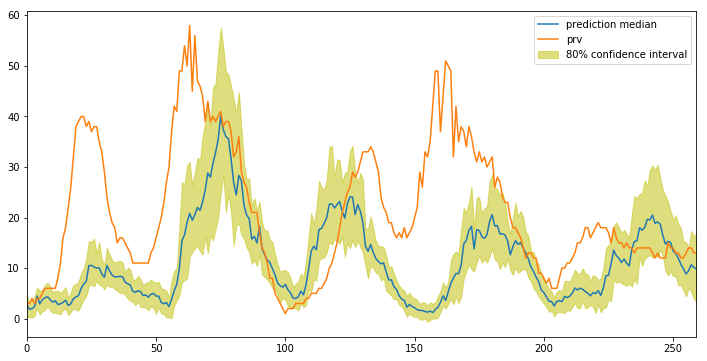

In [114]:
display_quantiles(predictions_sj, None)

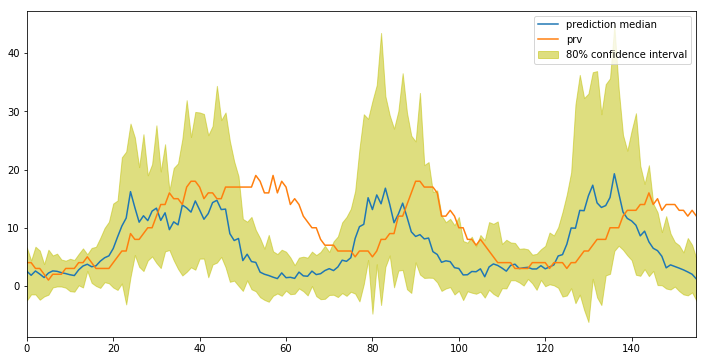

In [115]:
display_quantiles(predictions_iq, None)

In [112]:
predictions_iq.shape

(156, 9)

## Creating output CSV for submission

In [116]:
def create_submission(predictions_sj, predictions_iq, template_file='./data/submission_format.csv', output_dir='./submissions'):
    submission = pd.read_csv(template_file)
    submission.loc[submission.city=='iq', 'total_cases'] = predictions_iq['0.5'].tolist()
    submission.loc[submission.city=='sj', 'total_cases'] = predictions_sj['0.5'].tolist()
    submission['total_cases'] = submission['total_cases'].round().astype(int)
    submission.to_csv(f'{output_dir}/submission_{pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S_%f")}.csv', index=False)

In [117]:
create_submission(predictions_sj, predictions_iq)